# Fake News prediction

concept and defintion of fake news
where does the data come from
aim: detect fake news
...

## Libary import

In [2674]:
reset -fs

In [2675]:
%matplotlib inline
RSEED = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile

#preprocessing
import nltk 
from nltk.corpus import words
from nltk.probability import FreqDist
from nltk.util import ngrams
import re
from sklearn.model_selection import train_test_split

#EDA
from wordcloud import WordCloud

#model
from sklearn import model_selection

## for bag-of-words
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import feature_extraction, preprocessing, model_selection
from sklearn import feature_selection, metrics, naive_bayes, pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score


# word2vector
import gensim
import gensim.downloader as gensim_api
from sklearn import manifold
from sklearn.manifold import TSNE
from tensorflow.keras import models, layers, preprocessing as kprocessing
import tensorflow as tf
from keras.utils.vis_utils import pydot
from keras.utils import plot_model
from keras import backend as K

## bert language model
import transformers

#pipeline
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import cross_val_predict

## Loading data

In [2676]:
data = pd.read_csv('BuzzDataFull.csv')

In [2677]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627 entries, 0 to 1626
Data columns (total 6 columns):
article        1604 non-null object
author         1143 non-null object
title          1596 non-null object
orientation    1627 non-null object
veracity       1627 non-null object
portal         1627 non-null object
dtypes: object(6)
memory usage: 76.3+ KB


In [2678]:
data.sample(5)

article             author  \
1302  "For 30 years you’ve been doing it, and now yo...                NaN   
788   Another day in “Obama’s America”… another RIOT...           S. White   
1248  Hillary Clinton’s campaign is making one plea ...                NaN   
913   After months of quiet, mass shootings once aga...  Natalie Dickinson   
241   (CNN)Donald Trump reacted to a series of bombi...    By David Wright   

                                                  title orientation  \
1302  Trump is exaggerating Clinton's '30 years' in ...  mainstream   
788   NC MOB ATTACKS Female Trucker, Loots Truck, Se...       right   
1248    Clinton vs. Trump: The debate before the debate  mainstream   
913   JUST IN: Houston Mass Shooter Was Dressed In N...        left   
241   Trump reacts to bombings: 'This is only going ...  mainstream   

                       veracity            portal  
1302                mostly true          politico  
788   mixture of true and false     freedom-daily  
1248                mostly true          politico  
913                 mostly true  occupy-democrats  
241                 mostly true               cnn

In [2679]:
# create column and list with length of articles
data['article_len'] = data['article'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
article_len = []
for x in data.article_len:
    article_len.append(len(x.split()))
data['article_len'] = article_len

In [2680]:
# descriptive statistics of length of article
data['article_len'].describe()

count    1627.000000
mean      552.351567
std       548.778886
min         1.000000
25%       296.000000
50%       408.000000
75%       600.000000
max      5451.000000
Name: article_len, dtype: float64

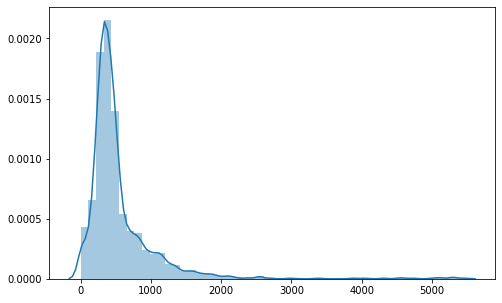

In [2681]:
# distribution of article length
plt.figure(figsize=(8,5))
ax = sns.distplot(article_len)

# Data cleaning

- check for missing values
- remove empty article
- check for duplicated article
- combine categories
- remove outlier
- remove very short article

## Missing Values

In [2682]:
#check for missing values
data.isnull().sum()

article         23
author         484
title           31
orientation      0
veracity         0
portal           0
article_len      0
dtype: int64

## Empty and duplicated article

In [2683]:
# find empty article
data.dropna(subset=['article'], inplace = True)

In [2684]:
#find empty article 
empty_list = data[data['article'] == 'The document has moved here.']
print(len(empty_list))
print(empty_list)

14
                          article      author              title orientation  \
562  The document has moved here.  Allen West  Moved Permanently       right   
567  The document has moved here.  Allen West  Moved Permanently       right   
593  The document has moved here.  Allen West  Moved Permanently       right   
597  The document has moved here.  Allen West  Moved Permanently       right   
621  The document has moved here.  Allen West  Moved Permanently       right   
624  The document has moved here.  Allen West  Moved Permanently       right   
648  The document has moved here.  Allen West  Moved Permanently       right   
651  The document has moved here.  Allen West  Moved Permanently       right   
682  The document has moved here.  Allen West  Moved Permanently       right   
686  The document has moved here.  Allen West  Moved Permanently       right   
712  The document has moved here.  Allen West  Moved Permanently       right   
716  The document has moved here.  Al

In [2685]:
# drop empty articles
data.drop(data[data['article'] == 'The document has moved here.'].index , inplace=True)
data.shape

(1590, 7)

In [2686]:
# find dupilcated article
dupl = data[data.duplicated(['article'])]
print(len(dupl))
print(dupl)

34
                                               article  \
272  (CNN)Former President Bill Clinton sought to a...   
285  Washington (CNN)The National Rifle Association...   
299  United Nations (CNN)President Barack Obama too...   
300  (CNN)Former President George H.W. Bush said Mo...   
313  Washington (CNN)The National Rifle Association...   
316  Washington (CNN)Republicans are preparing for ...   
317  Washington (CNN)The battle over gun rights ret...   
318  Washington (CNN)Senate Minority Leader Harry R...   
319  (CNN)Drawing enormous support from the state's...   
320  United Nations (CNN)President Barack Obama too...   
329  (CNN)Hillary Clinton's campaign manager said W...   
337  New York (CNN)President Barack Obama confronte...   
359  (CNN)Ukrainian President Petro Poroshenko says...   
361  (CNN)Michelle Obama on Tuesday joked about the...   
362  Washington (CNN)With two months to go before E...   
363  (CNN)A group of 375 "concerned" scientists -- ...   
364  Washin

In [2687]:
# remove duplicate
data.drop_duplicates(keep='first', inplace=True)
data.shape

(1557, 7)

In [2688]:
#removes = data.article.isin(["EDITOR’S NOTE:"]).index

In [2689]:
#CNN

## Set categories for classification problem

In [2690]:
# encode veracity(prediction) to number
# {'mixture of true and false': '0', 'mostly false': '1', 'mostly true': '2', 'no factual content': '3'}
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
data['veracity'] = LE.fit_transform(data['veracity'])

In [2691]:
#rename  = veracity to prediction
data.rename(columns={'veracity': 'prediction'}, inplace = True)

In [2692]:
data.prediction.value_counts()

2    1210
0     206
1      80
3      61
Name: prediction, dtype: int64

In [2693]:
print(data)

                                                article  \
0     With the Hillary Clinton-Donald Trump debates ...   
1     As police today captured the man wanted for qu...   
2     One day after explosive devices were discovere...   
3     Ahmad Khan Rahami, earlier named a person of i...   
4     Donald Trump's surrogates and leading supporte...   
5     One woman was killed and several children were...   
6     A Syrian human rights group said today that at...   
7     ABC News is bringing its original livestream s...   
8     Ivanka Trump now has her own Secret Service pr...   
9     President Barack Obama characterized Donald Tr...   
10    Rose Pak, a brash and lively community activis...   
11    One of the victims wounded in a stabbing at a ...   
12    A federal prosecutor told jurors on Monday tha...   
13    The recent connected bombings in New York and ...   
14    Ivanka Trump met privately with House Speaker ...   
15    In this final stretch before Election Day, the... 

In [2694]:
#combine and drop categories of prediciton (drop articles with no factual content)
data.prediction.unique()
data.prediction.value_counts()

2    1210
0     206
1      80
3      61
Name: prediction, dtype: int64

In [2695]:
#data.prediction.drop(['3'])
index_2 = data[data['prediction'] == 3].index
data.drop(index_2, inplace=True)

In [2696]:
data.shape

(1496, 7)

In [2697]:
# combine prediction of mostly & mixture of true and false since we are looking for fake news
# -> dataset with prediction: 0 = mostly True news
#                             1 = mostly Fake News & article with some fake news
data.prediction.replace(0, 1, inplace = True)
data.prediction.replace(2, 0, inplace = True)
data.prediction.value_counts()

0    1210
1     286
Name: prediction, dtype: int64

## Handling outliers
since we know that the distribution of length of words in the sample isn't Gaussian,
we can't use the standard deviation of the sample as a cut-off 
therefore we use Interquartile Range Method

In [2698]:
# calculate interquartile range
q25, q75 = percentile(data.article_len, 25), percentile(data.article_len, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [idx for idx,x in data.article_len.iteritems() if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data.article_len if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=307.000, 75th=599.500, IQR=292.500
Identified outliers: 161
Non-outlier observations: 1335


In [2699]:
# number of outliers
len(outliers)

161

In [2700]:
# remove outliers
data.drop(outliers, inplace=True)

In [2701]:
data.shape

(1335, 7)

In [2702]:
#find too short article (=less than 42 words)
short = data[data['article_len'] < 42].index
short

Int64Index([57, 262, 560], dtype='int64')

In [2703]:
# drop too short article 
data.drop(short, inplace=True)

In [2704]:
# save raw data and split in train and test for BERT
X = data['article']
y = data['prediction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

# Exploratory data analysis (EDA)

## Fake News and True News

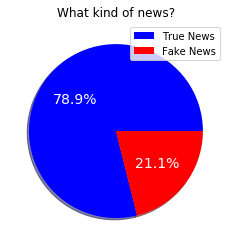

In [2705]:
Fig_age_survivial = (data.prediction.value_counts()
                     .plot.pie(autopct='%1.1f%%'
                               ,shadow=True
                               ,colors=['blue','red']
                               ,textprops=dict(color="w",size='14')
                               ,label='')
                    )
plt.title('What kind of news?')
plt.legend(['True News','Fake News'])
plt.savefig('figures/News_pie.png')

## Article length

In [2706]:
#create new dataframe for seaborn graphics
sbdata = data.copy()
sbdata.prediction = sbdata.prediction.map({ 0 : 'True', 1 : 'Fake'})
sbdata.rename(columns={'prediction': 'News'}, inplace = True)

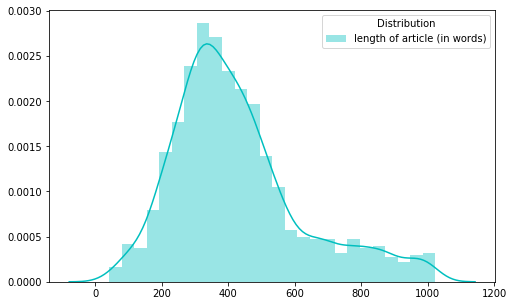

<Figure size 432x288 with 0 Axes>

In [2707]:
plt.figure(figsize=(8,5))
ax = sns.distplot(data['article_len'], color="c")
plt.legend(title='Distribution', loc='best', labels=['length of article (in words)'])
ax.set_xlabel('')
plt.show(ax)
plt.savefig('figures/Distribtion.png')

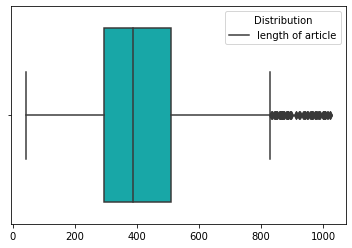

In [2708]:
# boxplot 
ax = sns.boxplot(x=sbdata['article_len'], color="c")
ax.set_xlabel('');
plt.legend(title='Distribution', loc='best', labels=['length of article']);
plt.savefig('figures/Boxplot_1.png')

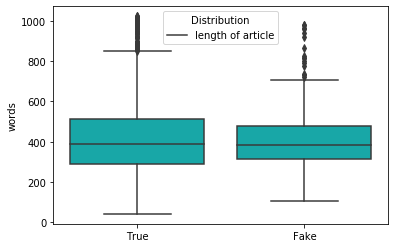

In [2709]:
# boxplot by prediction
ax = sns.boxplot(x="News", y='article_len', data=sbdata, color="c")
ax.set_ylabel('words')
ax.set_xlabel('')
plt.legend(title='Distribution', loc='best', labels=['length of article'])
plt.savefig('figures/Boxplot_2.png')

In [2710]:
data.shape

(1332, 7)

## Political orientation

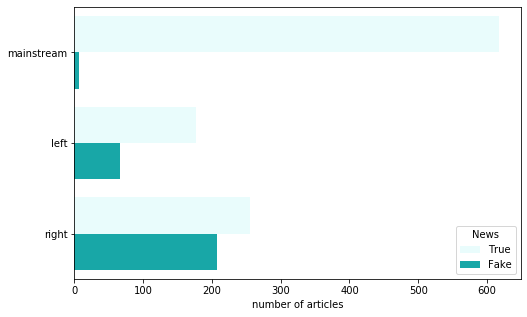

In [2711]:
f, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(y="orientation", hue="News", data=sbdata, color="c")
ax.set_ylabel('')
ax.set_xlabel('number of articles')
plt.savefig('figures/orientation.png')

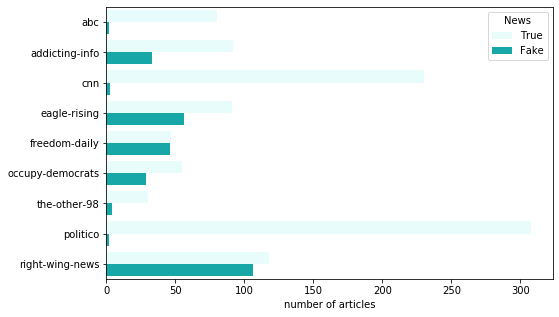

In [2712]:
f, ax = plt.subplots(figsize=(8, 5));
sns.countplot(y="portal", hue="News", data=sbdata, color="c")
ax.set_ylabel('')
ax.set_xlabel('number of articles')
plt.savefig('figures/news_source.png')

# Preprocessing

In [2713]:
print(data.shape)

(1332, 7)


In [2714]:
text = data['article']
label = data['prediction']

In [2715]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332 entries, 1 to 1626
Data columns (total 7 columns):
article        1332 non-null object
author         972 non-null object
title          1319 non-null object
orientation    1332 non-null object
prediction     1332 non-null int64
portal         1332 non-null object
article_len    1332 non-null int64
dtypes: int64(2), object(5)
memory usage: 83.2+ KB


In [2716]:
print(data.article[126])

Guess who George H.W. Bush is voting for? He lost to Bill Clinton in 1992, and his son is George W. Bush. Yet it seems that the elder Bush finds Trump so distasteful a candidate that heâs actually going to cast his vote for Hillary Clinton. According to Bush Sr. had originally planned on keeping quiet about this election. Considering the fact that heâs a Republican, and therefore expected to weigh in on the side of the Republicansâ chosen candidate, this is actually pretty major. But it wasnât Bush himself who revealed his vote. It was Kathleen Kennedy Townsendâdaughter of the late Robert Kennedyâwho let this particular interesting tidbit slip: âOn Monday, Townsend posted a picture on her Facebook page shaking hands next to the former president and this caption: âThe President told me heâs voting for Hillary!!'â She stood by that later on when talking to According to her, George H.W. Bush would rather vote for his former rival and successorâs wife than the god-awf

In [2717]:
# define stopwords (commonly used words which search engine has been programmed to ignore)
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.append('hi')
print(lst_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

preprocessing includes:
- remove punctuations and set lowercase
- tokenize
- remove stopwords
- remove URL's
- remove twitter names
- lemmatization

In [2718]:
# code for preprocessing inluding lemmatization

def preprocess_text_lemm(text, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    
    ## remove URL
    text = re.sub(r'http\S+', '', text)
    
    ## remove twitter
    text = re.sub('@[^\s]+','', text)
        
    # lemmatization
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [2719]:
''' code for stemming, we use lemmatization instead, because of better results

def preprocess_text_lemm(text, flg_stemm=True, lst_stopwords=None):
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    
    ## remove URL
    text = re.sub(r'http\S+', '', text)
    
    ## remove twitter
    text = re.sub('@[^\s]+','', text)
               
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
        
    
    ## back to string from list
    text = " ".join(lst_text)
    return text
'''

' code for stemming, we use lemmatization instead, because of better results\n\ndef preprocess_text_lemm(text, flg_stemm=True, lst_stopwords=None):\n    \n    ## clean (convert to lowercase and remove punctuations and characters and then strip)\n    text = re.sub(r\'[^\\w\\s]\', \'\', str(text).lower().strip())\n            \n    ## Tokenize (convert from string to list)\n    lst_text = text.split()\n    ## remove stopwords\n    if lst_stopwords is not None:\n        lst_text = [word for word in lst_text if word not in \n                    lst_stopwords]\n    \n    ## remove URL\n    text = re.sub(r\'http\\S+\', \'\', text)\n    \n    ## remove twitter\n    text = re.sub(\'@[^\\s]+\',\'\', text)\n               \n    ## Stemming (remove -ing, -ly, ...)\n    if flg_stemm == True:\n        ps = nltk.stem.porter.PorterStemmer()\n        lst_text = [ps.stem(word) for word in lst_text]\n        \n    \n    ## back to string from list\n    text = " ".join(lst_text)\n    return text\n'

In [2720]:
## save preprocessed text
data["text"] = data["article"].apply(lambda x: 
          preprocess_text_lemm(x, flg_lemm=True, lst_stopwords=lst_stopwords))

In [2721]:
print(data.head())
print(data.shape)

                                             article  \
1  As police today captured the man wanted for qu...   
2  One day after explosive devices were discovere...   
4  Donald Trump's surrogates and leading supporte...   
5  One woman was killed and several children were...   
6  A Syrian human rights group said today that at...   

                                              author  \
1  Brian Ross Rhonda Schwartz Mike Levine Stephan...   
2                                     ALANA ABRAMSON   
4                                      Candace Smith   
5                                         Lena Masri   
6                 Elizabeth McLaughlin Ben Gittleson   

                                               title orientation  prediction  \
1  Details Emerge About NYC Bomb Suspect Ahmad Kh...  mainstream           0   
2  Donald Trump Repeats Calls for Police Profilin...  mainstream           0   
4  Trump Surrogates Push Narrative That Clinton S...  mainstream           0   
5  1 W

# Model

### Split train and test data

In [2722]:
X_l = data['text']
y_l = data['prediction']
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.3, random_state=RSEED)

In [2723]:
print(X_l_train.shape)
print(y_l_train.shape)
print(X_l_test.shape)
print(y_l_test.shape)

(932,)
(932,)
(400,)
(400,)


### Word cloud

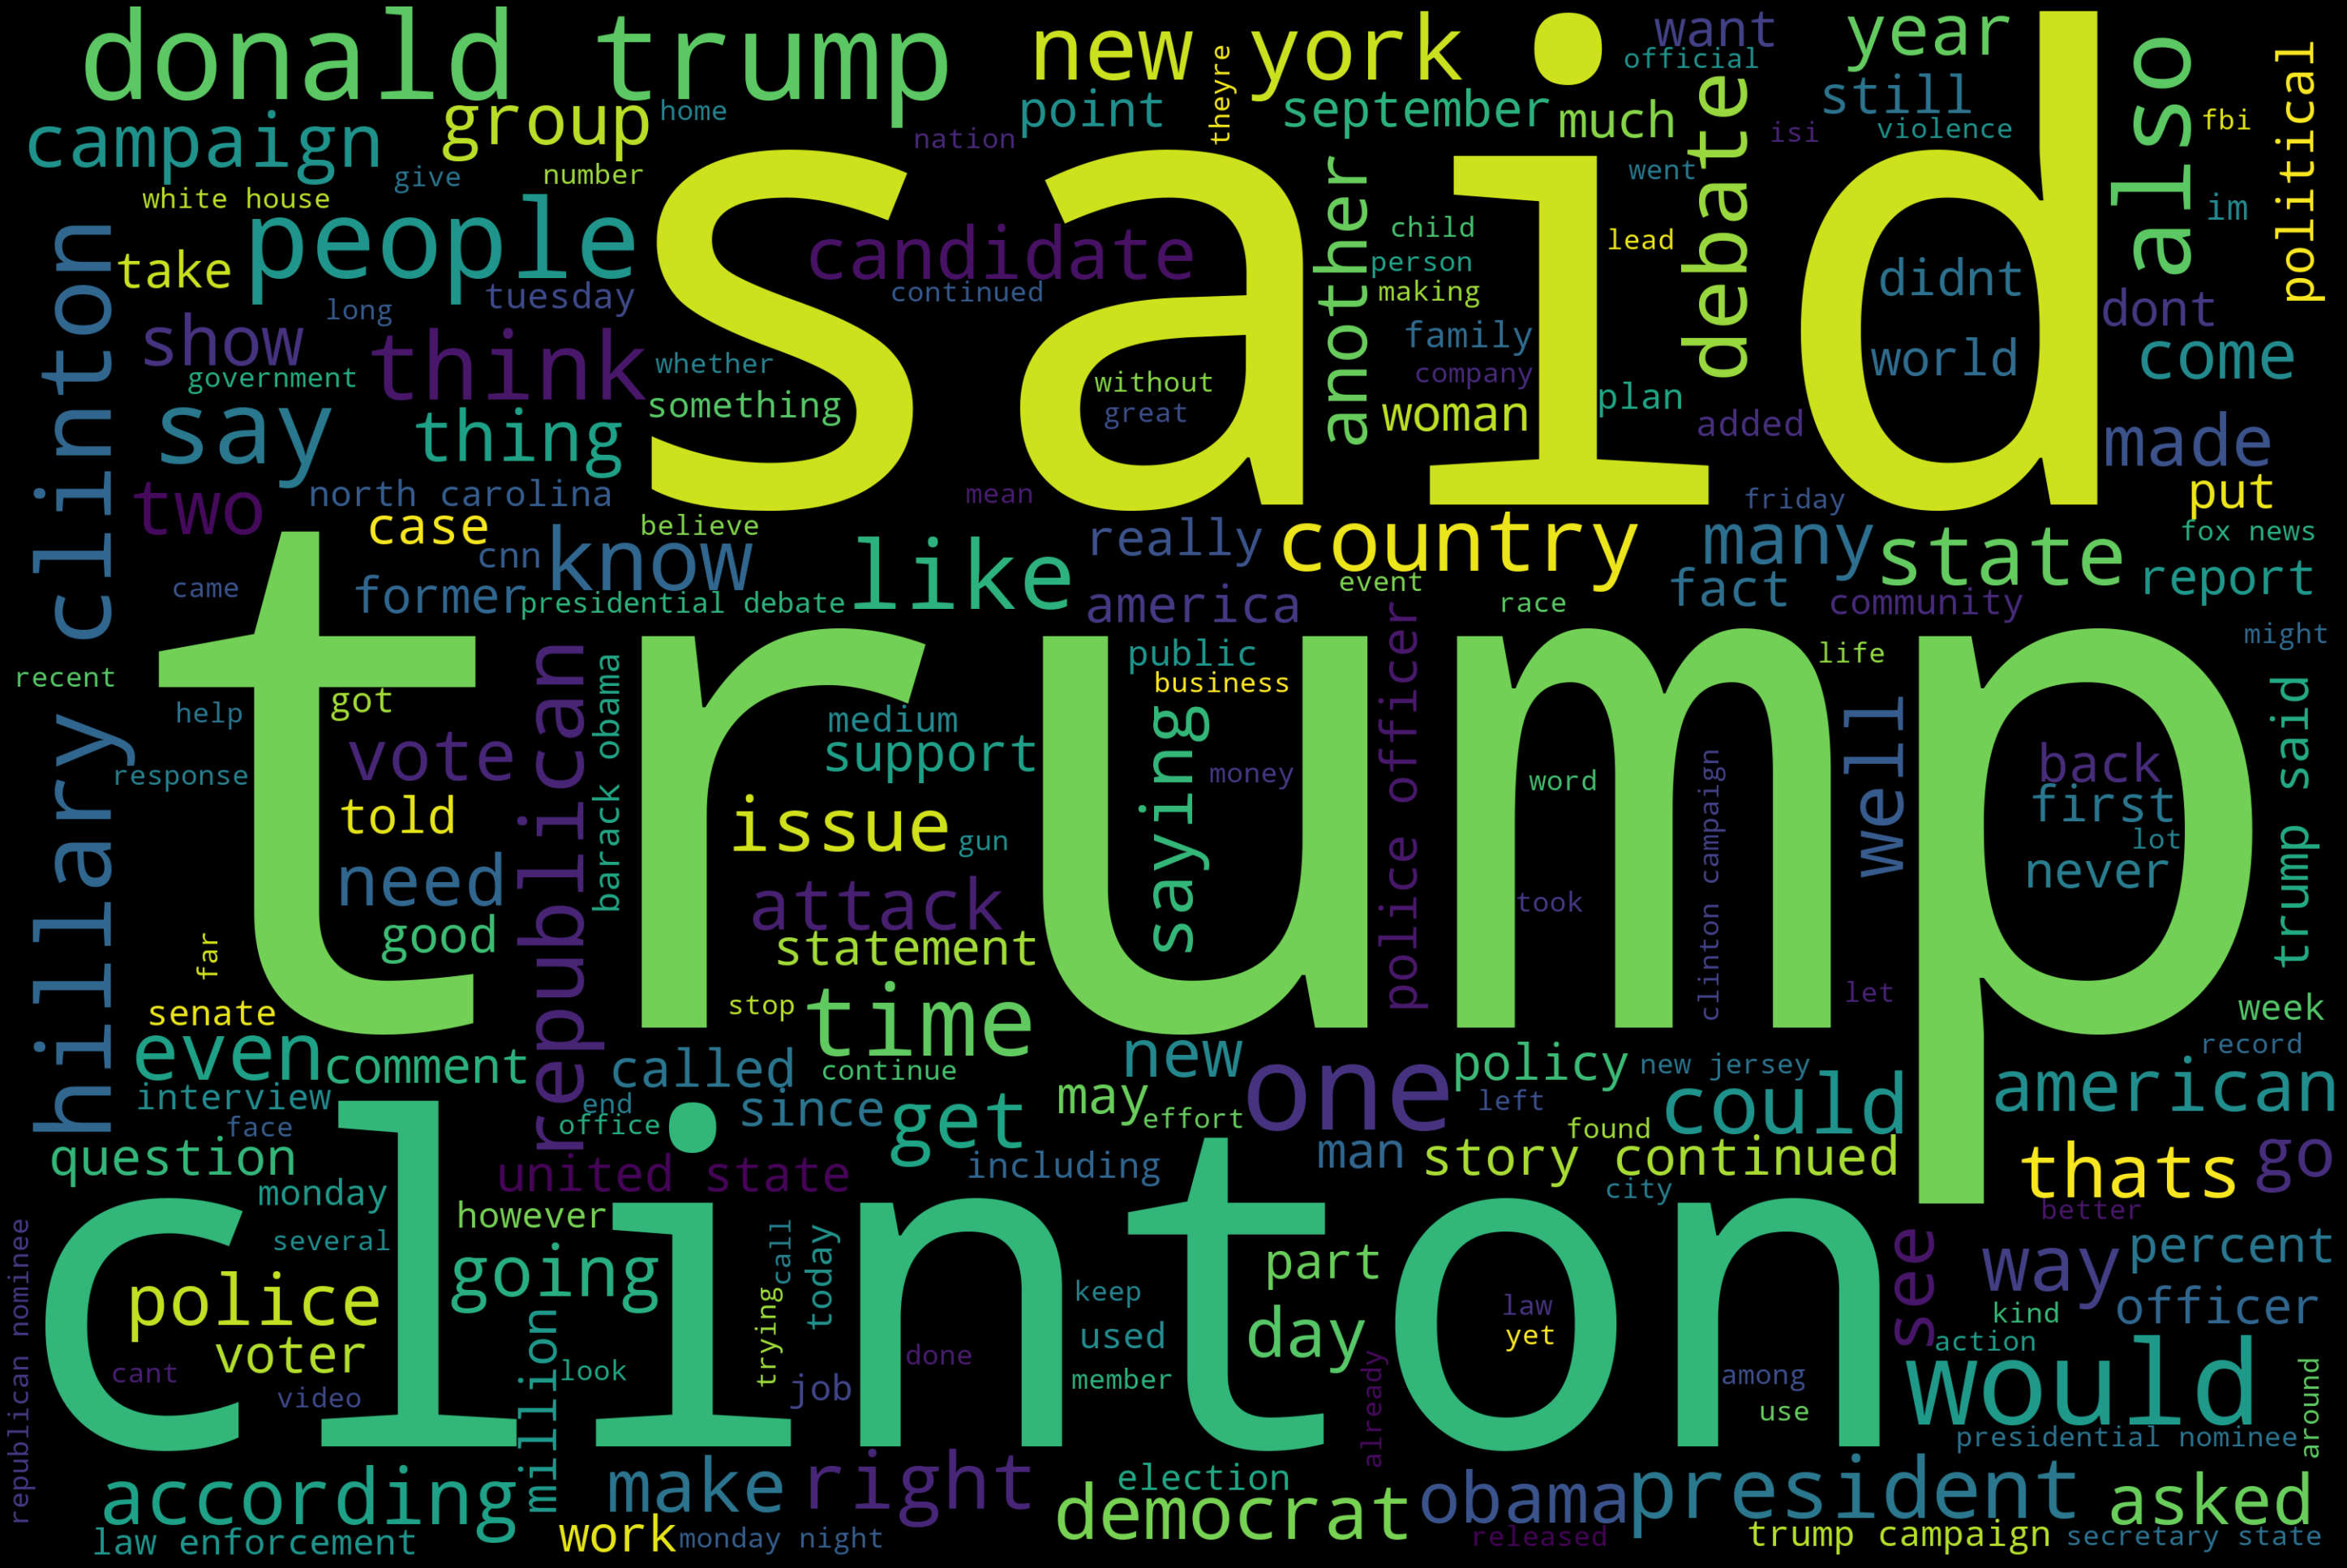

In [2724]:
#Word Cloud for data true news
lst_true = ''
for news in data[data.prediction==0].text.values:
    lst_true += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(lst_true)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
wordcloud.to_file('figures/Wordcloud_true.png')

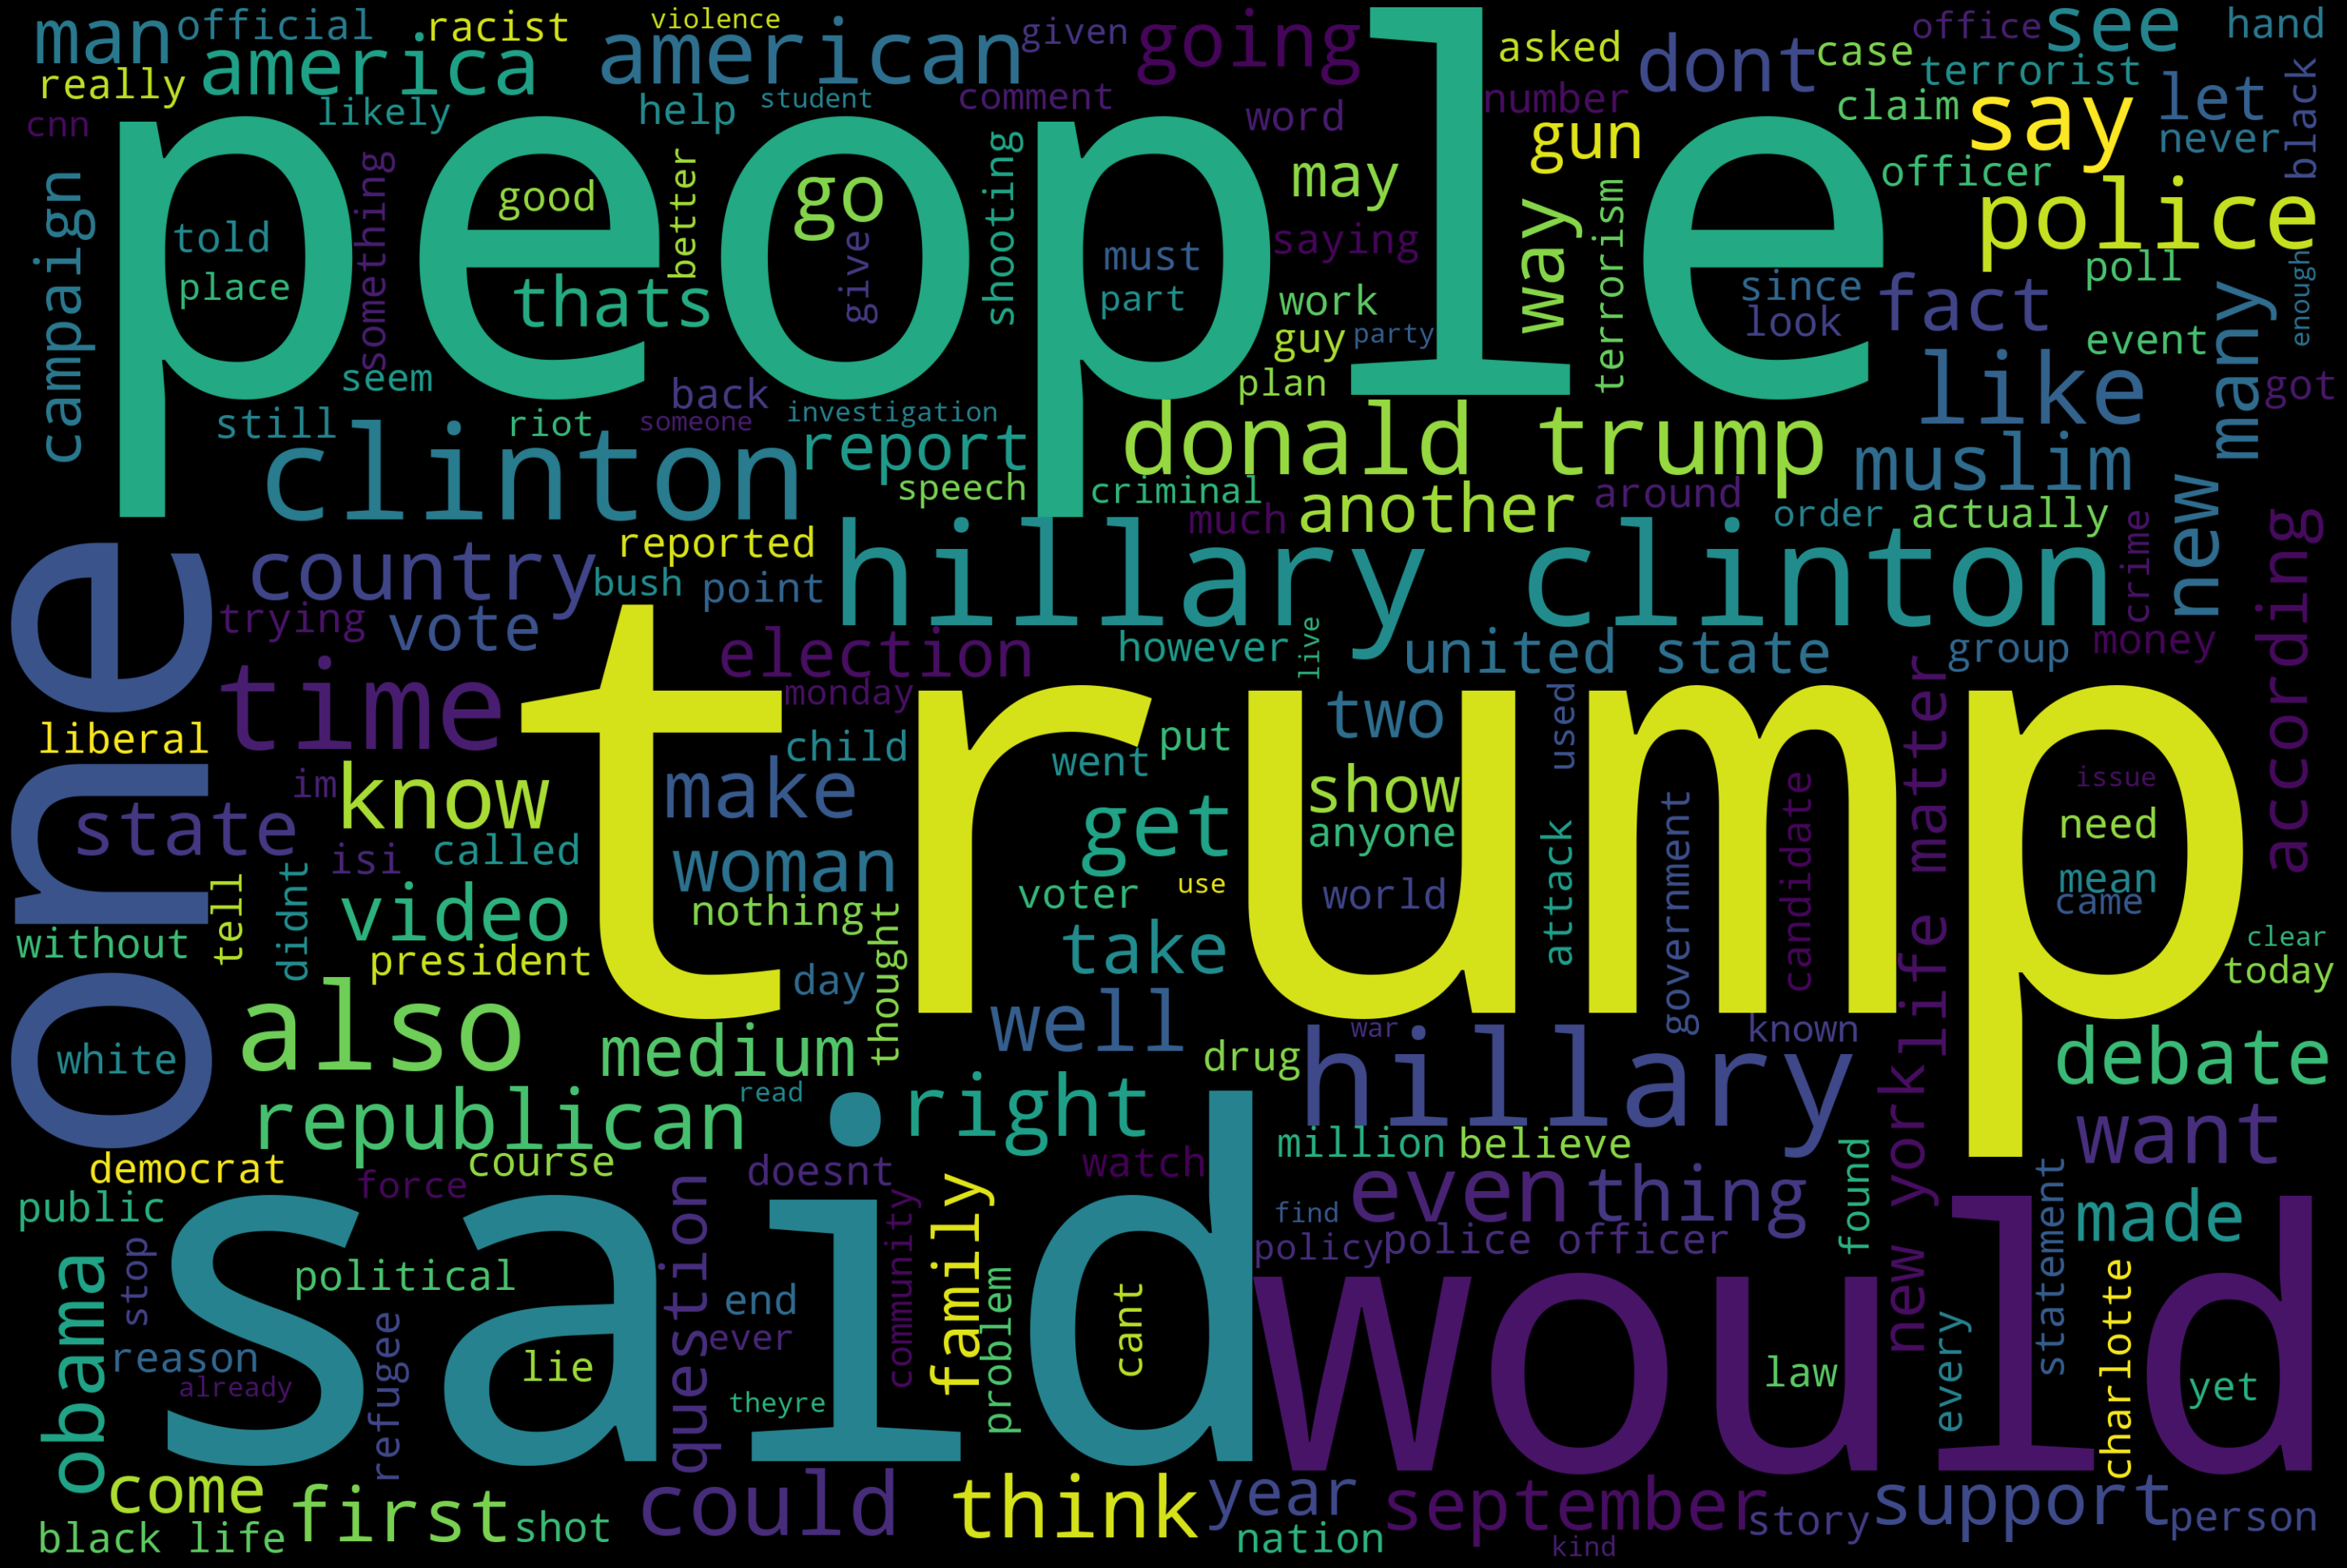

In [2725]:
#Word Cloud for data fake news
lst_fake = ''
for news in data[data.prediction==1].text.values:
    lst_fake += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(lst_fake)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
wordcloud.to_file('figures/Wordcloud_fake.png')

### Token

In [2726]:
lst_true

' police today captured man wanted questioning connection series explosive device new york city new jersey new information begun emerge man ahmad khan rahami 28 born 1988 afghanistan naturalized u citizen according fbi discovered captured linden new jersey far last known address elizabeth u official initially told abc news rahami came u 2000 father later said family came 1995 court record indicate ahmad rahami large family may many seven sibling former classmate said attended edison high school new jersey one chris konya said rahami quiet funny pretty normal guy konya another former classmate said rahami child high school girlfriend rahami enrolled middlesex county college fall 2010 fall 2012 worked toward associate degree criminal justice graduate according school official rahami family owned fried chicken restaurant elizabeth employee recent customer said rahami worked come every week two get something eat local resident ryan mccann told associated press he always he friendly guy tha

In [2727]:
# total tokens
print(len(lst_true))
print(len(lst_fake))

1841194
461807


In [2728]:
# unique tokens
print(len(set(nltk.word_tokenize(lst_true))))
print(len(set(nltk.word_tokenize(lst_fake))))

19857
10272


In [2729]:
# lexical diversity (ratio of unique tokens to the total number of tokens)
print(len(set(lst_true))/float(len(lst_true)))
print(len(set(lst_fake))/float(len(lst_fake)))

3.0415045888700486e-05
9.960871099831748e-05


In [2730]:
true_freq = FreqDist(lst_true)
fake_freq = FreqDist(lst_fake)

In [2731]:
true_freq_frame = pd.DataFrame(true_freq.most_common(),
                                        columns=["token", "frequency"])

In [2732]:
frame =  true_freq_frame[true_freq_frame.token.str.len() > 0]
sorted(frame.token)

[' ',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'à',
 'á',
 'â',
 'ã',
 'ç',
 'è',
 'é',
 'í',
 'ï',
 'ð',
 'ñ',
 'ü',
 'č',
 'ē',
 'ğ',
 'ڰ',
 'ڿ',
 'ღ']

In [2733]:
print(y_l_train.shape)
print(y_l_test.shape)

(932,)
(400,)


## Bag-of-Words with Tf-Idf (Term Frequency - Inverse Document Frequency)

Bag-of-Words model in general builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. Each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (-> “bag of words”) 

But instead of simple counting, we use the term frequency–inverse document frequency (or Tf–Idf). Basically, the value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.

- Load pre-trained model (Tf-Idf)
- Features Engineering
- Features Selection
- Model Design
- Evaluate

### Load pre-trained model (Tf-Idf)

In [2734]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2),lowercase=False)

### Feature engineering

create features by extracting information from the data

In [2735]:
## create vectorizer
corpus = X_l_train
vectorizer.fit(corpus)
X_l_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [2736]:
## create vocabulary
dic_vocabulary = vectorizer.vocabulary_
len(dic_vocabulary)

10000

In [2737]:
## tokenization
tokenizer = vectorizer.build_tokenizer()
preprocessor = vectorizer.build_preprocessor()
lst_text2tokens = []
for text in corpus:
    lst_tokens = [dic_vocabulary[word] for word in tokenizer(preprocessor(text)) if word in dic_vocabulary]
    lst_text2tokens.append(lst_tokens)
print(len(lst_text2tokens))

932


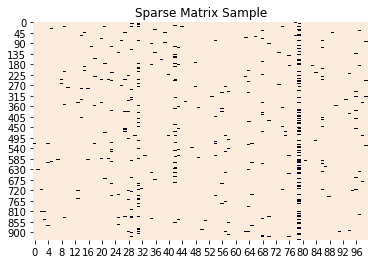

In [2738]:
# create sparse matrix
sns.heatmap(X_l_train.todense()[:,np.random.randint(0,X_l_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

In [2739]:
# test
word = "trump"
dic_vocabulary[word]

9047

### Feature selection

In order to drop some columns and reduce the matrix dimensionality by selecting a subset of relevant variables:

- perform a Chi-Square test to determine whether a feature and the target are independent

- keep only the features with a certain p-value from the Chi-Square test

In [2740]:
#Perform feature selection using p-values (keep highly correlated features)
def features_selection(X_train, y_train, X_names, top=None, print_top=10):    
    ## selection
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>0.50] #p-value filter
    if top is not None:
        dtf_features = dtf_features.groupby('y')["y","feature","score"].head(top)
    
    ## print
    print("features selection: from", "{:,.0f}".format(len(X_names)), 
          "to", "{:,.0f}".format(len(dtf_features["feature"].unique())))
    print(" ")
    for cat in np.unique(y):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ", ".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:print_top]))
        print(" ")
    return dtf_features["feature"].unique().tolist(), dtf_features


In [2741]:
#give features with p-value >0.50
y = y_l_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.50
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_l_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [2742]:
dtf_features.loc[dtf_features['y'] == 0].head(10)

feature     score  y
1832  combetta  0.964425  0
4084   hillary  0.963260  0
2803      drug  0.960505  0
7112    reddit  0.941687  0
7934    sharia  0.926582  0
2100  coughing  0.924891  0
8968  townsend  0.903498  0
3924     haiti  0.902220  0
1076     black  0.896796  0
8859      thug  0.887542  0

In [2743]:
dtf_features.loc[dtf_features['y'] == 1].head(10)

feature     score  y
1832  combetta  0.964425  1
4084   hillary  0.963260  1
2803      drug  0.960505  1
7112    reddit  0.941687  1
7934    sharia  0.926582  1
2100  coughing  0.924891  1
8968  townsend  0.903498  1
3924     haiti  0.902220  1
1076     black  0.896796  1
8859      thug  0.887542  1

In [2744]:
print(len(X_names))
print(len(dtf_features))

595
1190


In [2745]:
#refit the vectorizer on the corpus by giving this new set of words as input
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_l_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [2746]:
dic_vocabulary

{'combetta': 0,
 'hillary': 1,
 'drug': 2,
 'reddit': 3,
 'sharia': 4,
 'coughing': 5,
 'townsend': 6,
 'haiti': 7,
 'black': 8,
 'thug': 9,
 'cough': 10,
 'alien': 11,
 'puzder': 12,
 'avaaz': 13,
 'muslim': 14,
 'illegal': 15,
 'said': 16,
 'sharia law': 17,
 'earpiece': 18,
 'brennan': 19,
 'mcchrystal': 20,
 'beat': 21,
 'life matter': 22,
 'wccb': 23,
 'tebow': 24,
 'photographer': 25,
 'lafarge': 26,
 'pander': 27,
 'halal': 28,
 'oppressed': 29,
 'feminist': 30,
 'black life': 31,
 'haitian': 32,
 'coughing fit': 33,
 'corruption': 34,
 'ranbaxy': 35,
 'islam': 36,
 'literally': 37,
 'klepper': 38,
 'clinton health': 39,
 'criminal alien': 40,
 'daisy': 41,
 'gateway': 42,
 'gateway pundit': 43,
 'hashtag': 44,
 'blacklivesmatter': 45,
 'story continued': 46,
 'intimidation': 47,
 'radical islam': 48,
 'hillary actually': 49,
 'paul combetta': 50,
 'theyâll': 51,
 'breitbart': 52,
 'foreigner': 53,
 'stonetear': 54,
 'wilson': 55,
 'hate group': 56,
 'one guy': 57,
 'kennedy tow

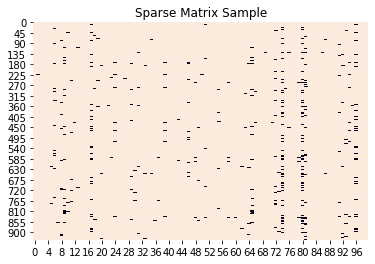

In [2747]:
sns.heatmap(X_l_train.todense()[:,np.random.randint(0,X_l_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample');

### Model design

For classification we are using:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBboost
- Adaboost

In [2748]:
# define classifiers
classifiers={
        'logreg': LogisticRegression(max_iter=1000, random_state=RSEED,n_jobs=-1),
        'tree': DecisionTreeClassifier(criterion = "gini", max_depth=3,random_state=RSEED),
        'forest': RandomForestClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1),
        'XGB' : XGBClassifier(seed=RSEED,  n_jobs=-1),
        'AdaBoost' : AdaBoostClassifier(random_state=RSEED)}

In [2749]:
results = pd.DataFrame(columns=['Model','Accuracy','Recall','Precision', 'F1'])
i=0
for classifier in classifiers.items():
    # Building a full pipeline with scaler to balance the data and a classifier
    pipe = imbPipeline([
        ('ADASYN', ADASYN(random_state=RSEED)),
        (classifier[0], classifier[1])
    ])
    # Making predictions on the training set using cross validation as well as calculating the probabilities 
    y_l_train_predicted = cross_val_predict(pipe, X_l_train, y_l_train.values.ravel(), cv=5, verbose=5)
    # Calculating the accuracy for Classifier
    temp = pd.DataFrame({
        'Model': classifier[0],
        'Accuracy': accuracy_score(y_l_train, y_l_train_predicted),
        'Recall' : recall_score(y_l_train, y_l_train_predicted),
        'Precision': precision_score(y_l_train, y_l_train_predicted),
        'F1': f1_score(y_l_train, y_l_train_predicted),
        'ROC-AUC': roc_auc_score(y_l_train, y_l_train_predicted)
    }, index=[i])
    i+=1
    results = pd.concat([results, temp])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished
/Users/rudigerhass/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n

### Evaluation

In [2750]:
results

Accuracy        F1     Model  Precision   ROC-AUC    Recall
0  0.792918  0.626692    logreg   0.514286  0.796196  0.801980
1  0.769313  0.508009      tree   0.472340  0.689821  0.549505
2  0.840129  0.520900    forest   0.743119  0.681317  0.400990
3  0.819742  0.562500       XGB   0.593407  0.716642  0.534653
4  0.822961  0.582278  AdaBoost   0.595855  0.731229  0.569307

### Softvoting

In [2751]:
eclf1 = VotingClassifier(estimators=[
       ('lr', LogisticRegression)], voting='soft')

## Word Embedding with Word2Vec

Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers. These vectors are calculated from the probability distribution for each word appearing before or after another.
Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space

In [2752]:
# split dataset in train and test
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.3, random_state=RSEED)

### Common n-grams detectors

Before starting with our embedding model, we create an n-grams model which predicts the most probable word that might follow this sequence

In [2753]:
def create_ngrams_detectors(corpus, grams_join=" ", lst_common_terms=[], min_count=5, top=10, figsize=(10,7)):
    ## fit models
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=1, grams_join=grams_join)
    bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=grams_join.encode(), common_terms=lst_common_terms, min_count=min_count, threshold=min_count*2)
    bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
    trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=grams_join.encode(), common_terms=lst_common_terms, min_count=min_count, threshold=min_count*2)
    trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

    ## plot
    dtf_ngrams = pd.DataFrame([{"word":grams_join.join([gram.decode() for gram in k]), "freq":v} for k,v in trigrams_detector.phrasegrams.items()])
    dtf_ngrams["ngrams"] = dtf_ngrams["word"].apply(lambda x: x.count(grams_join)+1)
    dtf_ngrams = dtf_ngrams.sort_values(["ngrams","freq"], ascending=[True,False])
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_ngrams.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return [bigrams_detector, trigrams_detector], dtf_ngrams


In [2754]:
def utils_preprocess_ngrams(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[]):
    ## create list of n-grams
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [grams_join.join(lst_words[i:i + ngrams]) for i in range(0, len(lst_words), ngrams)]
        lst_corpus.append(lst_grams)
    
    ## detect common bi-grams and tri-grams
    if len(lst_ngrams_detectors) != 0:
        for detector in lst_ngrams_detectors:
            lst_corpus = list(detector[lst_corpus])
    return lst_corpus

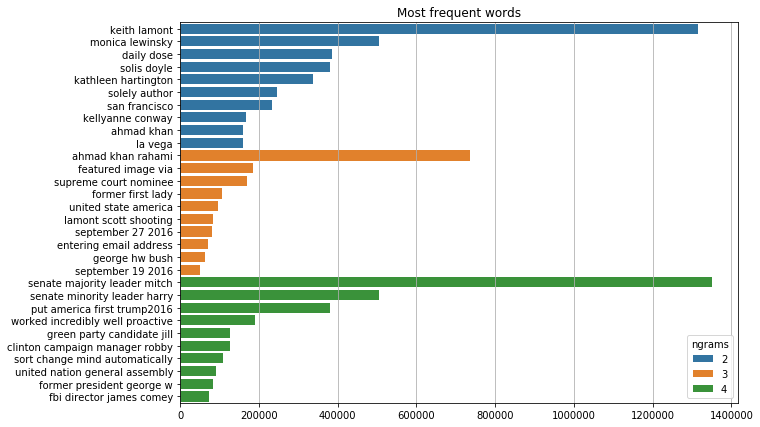

In [2755]:
lst_ngrams_detectors, dtf_ngrams = create_ngrams_detectors(corpus=X_l, min_count=5, top=10, figsize=(10,7))

### Train Model (Word2Vec)

In [2756]:
# set corpus
corpus = X_l_train

In [2757]:
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [2760]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [2765]:
print(nlp)

Word2Vec(vocab=19043, size=300, alpha=0.025)


/Users/rudigerhass/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Users/rudigerhass/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/Users/rudigerhass/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Users/rudigerhass/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



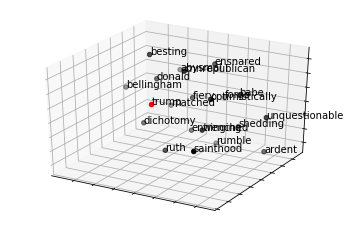

In [2657]:
# select word

word = "trump"
nlp[word].shape
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 300 to 3 b(y using TSNE)
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### Feature Engineering

From here word vectors can be used in a neural network as weights by following these steps:

- Transform corpus into padded sequences of word ids to get a feature matrix.
- Create an embedding matrix so that the vector of the word with id N is located at the Nth row.
- Build a neural network with an embedding layer that weighs every word in the sequences with the   corresponding vector.

In [2658]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_l_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=10, padding="post", truncating="post")

In [2659]:
# every text in the corpus is now an id sequence with length 10
print(X_l_train.shape)

(932, 10)


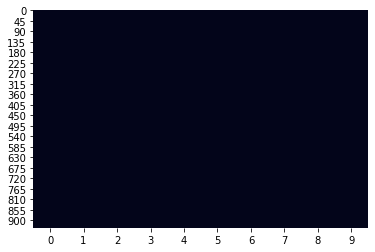

In [2660]:
sns.heatmap(X_l_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [2661]:
# do the same for test data
corpus = X_l_test

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_l_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=10,
             padding="post", truncating="post")

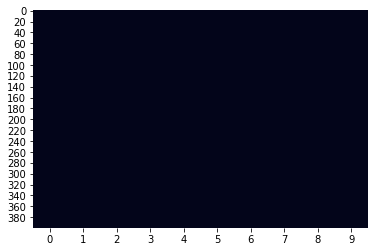

In [2662]:
sns.heatmap(X_l_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [2663]:
#matrix of embedding -> will be used as a weight matrix in the neural network classifier

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/Users/rudigerhass/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [2665]:
word = "trump"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 2 |idx
embeddings[idx]: (300,) |vector


In [ ]:
#python -m gensim.scripts.word2vec2tensor -i INPUT_FILE_PATH -o OUTPUT_FILE_PATH

### Model design

In [ ]:
### backstopper

#tf.keras.callbacks.EarlyStopping(
#    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
#    baseline=None, restore_best_weights=False
#)

In [2666]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(10,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=10, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=10)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=10, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=10, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 10, 300)      5713500     input_5[0][0]                    
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 300, 10)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 300, 10)      110         permute_4[0][0]                  
____________________________________________________________________________________________

Train the model and check the performance on a subset of the training set used for validation before testing it on the actual test set

In [2667]:
X_l_train = np.asarray(X_l_train)
y_l_train = np.asarray(y_l_train)

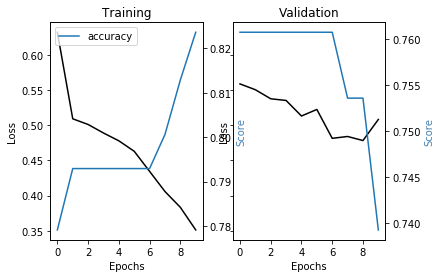

In [2668]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_l_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_l_train = np.array([inverse_dic[y] for y in y_l_train])
## train
training = model.fit(x=X_l_train, y=y_l_train, batch_size=32, 
                     epochs=10, shuffle=True, verbose=0, validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

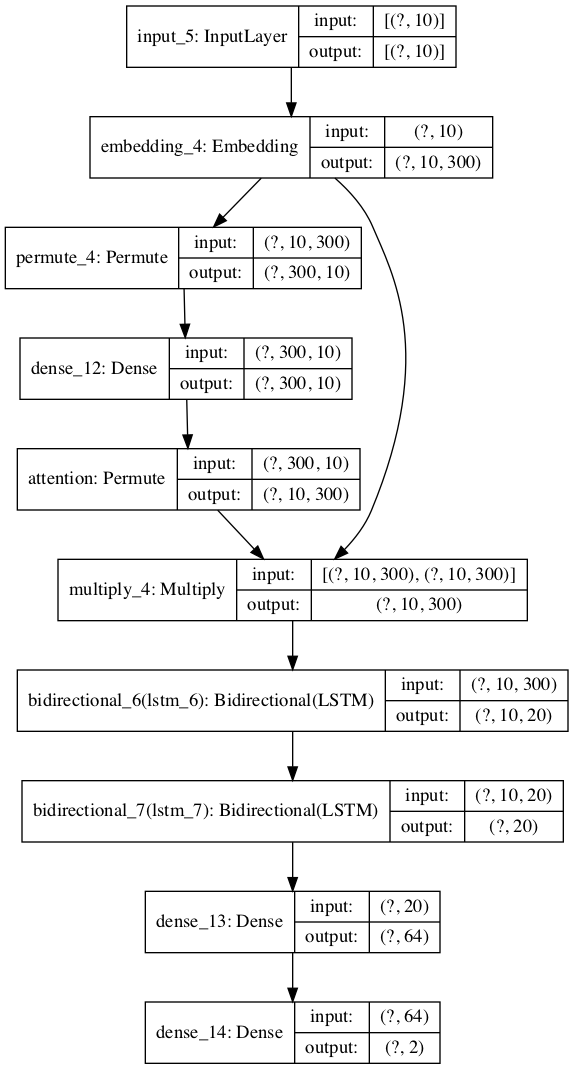

In [2669]:
#show model 
tf.keras.utils.plot_model(model, show_shapes=True)

In [2670]:
## test data
predicted_prob = model.predict(X_l_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [2671]:
X_l_train = np.asarray(X_l_train)
y_l_train = np.asarray(y_l_train)

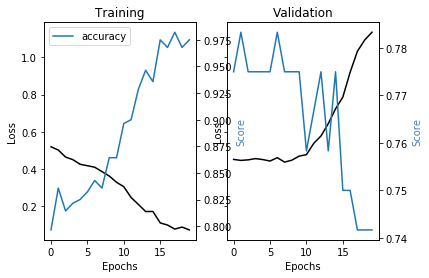

In [2672]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_l_test))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_l_test = np.array([inverse_dic[y] for y in y_l_test])
## train
training = model.fit(x=X_l_test, y=y_l_test, batch_size=32, 
                     epochs=20, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Put an Attention layer in the neural network to extract the weights of each word and understand how much those contributed to classify an instance. So I’ll try to use Attention weights to build an explainer (similar to the one seen in the previous section):

In [2673]:
## select observation
i = 42
txt_instance = y_l.iloc[i]
## check true value and predicted value
print("True:", y_l_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=10, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
#weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
#          != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
    dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
    dtf.sort_values(by="score", 
           ascending=True).tail(10).plot(kind="barh", 
           legend=False).grid(axis='x')
    plt.show()
else:
    print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

True: 0 --> Pred: 0 | Prob: 0.74


AttributeError: 'numpy.int64' object has no attribute 'lower'

## Language Model with BERT

Language model overcomes the biggest limitation of the classic Word Embedding approach: polysemy disambiguation (a word with different meanings) is identified by just one vector

Google’s BERT (Bidirectional Encoder Representations from Transformers, 2018) combines ELMO context embedding and several Transformers, plus it’s bidirectional (which was a big novelty for Transformers). The vector BERT assigns to a word is a function of the entire sentence, therefore, a word can have different vectors based on the contexts

For Fine-tuning the pre-trained model (transfer learning), I use a lighter version of BERT, called Distil-BERT (-> https://huggingface.co/transformers/model_doc/distilbert.html)

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling Bert base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of Bert’s performances as measured on the GLUE language understanding benchmark.

## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

### Feature Engineering

Please note that I’m using the raw text as corpus (so far I’ve been using the clean_text column)

corpus = data["text"] #training data???
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [ ]:
#X_train.shape()

i = 0
print("txt: ", data["text"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

#same for test data
corpus = data["text"] ### TEST DATA!!!
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

### Deep learning model with transfer learning

- Summarize the output of BERT into one vector with Average Pooling 
- Add two final Dense layers to predict the probability of each news category

## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_l_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

### Train, test, evaluate model

## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_l_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_l_train = np.array([inverse_dic[y] for y in y_l_train])
## train
training = model.fit(x=X_l_train, y=y_l_train, batch_size=32, 
                     epochs=1, shuffle=True, verbose=1, 
                     validation_split=0.3)

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

#test data
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]